# W to tau branching ratios



In [25]:
# imports and configuration
%cd '/home/naodell/work/CMS/z_plus_jpsi'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.stats import chi2, beta
import numdifftools as nd

import scripts.plot_tools as pt
import scripts.fit_helpers as fh

matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/CMS/z_plus_jpsi


In [26]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bayesian_block_baseline/'
beta_type  = 'pdg'
#selections = ['mumu', 'emu', 'mutau']
selections = ['mumu', 'mutau', 'mu4j', 'emu']#, 'ee', 'etau', 'e4j']
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )

fit_data = dict(selections=selections, n_selections=len(selections))
for selection in selections:
    fit_data[selection] = fh.get_template_data(input_dir, targets[selection], selection)

In [27]:
# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h)
mask = [0, 0, 0, 0]
if beta_type == 'pdg':
    beta_init = [0.1065, 0.1059, 0.114, 0.676]
    var_beta  = [0.0017**2, 0.0015**2, 0.0022**2, 0.0031**2]
elif beta_type == 'lu':
    beta_init = [0.108, 0.108, 0.108, 0.676] # lepton universality (lep average)
    var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initial values for tau branching fraction (b_e, b_mu, beta_h)
br_tau = [0.1783, 0.1741, 0.6476]

# first parameter is for the background component
bg_init, bg_var_init = [], []
for selection in fit_data['selections']:
    alpha_bg, alpha_var_bg = fit_data[selection]['bg_init']
    bg_init.append(1.)
    bg_var_init.append(1e-3)
    
p_init = dict(vals = np.array([1] + bg_init + beta_init),
              var  = np.array([1e-3] + bg_var_init + var_beta),
              mask = np.array([1] + len(selections)*[1, ] + mask)
             )

fit_data['br_tau']       = br_tau
fit_data['p_init']       = p_init
fit_data['bounds']       = [(0., 2.)] + len(selections)*[(0., 2.), ] + 4*[(0, 1.), ] #[(0.104, 0.109), (0.10, 0.12), (0, 1), (0.674, 679)]
fit_data['constraints']  = [
                            dict(type = 'eq', fun = partial(fh.param_constraint_unitary, ix_beta=1 + len(selections))),
                            #dict(type = 'eq', fun = fh.param_constraint_prior)
                           ]

In [28]:
# carry out fit
result = minimize(fh.mixture_cost,
                  fit_data['p_init']['vals'],
                  method      = 'SLSQP',
                  bounds      = fit_data['bounds'],
                  constraints = fit_data['constraints'],
                  args        = (fit_data, )
                 ) 
f_cost = partial(fh.mixture_cost, fit_data=fit_data)
sig, corr_matrix = fh.calculate_covariance(f_cost, result.x)

fit_data['results'] = result
fit_data['results_sig'] = sig
fit_data['results_corr'] = corr_matrix

In [29]:
# print fit results
np.set_printoptions(precision=4)
pd.set_option('precision', 4)

labels = ['C'] + [f'alpha_bg_{s}' for s in selections] + ['beta_e', 'beta_mu', 'beta_tau', 'beta_h']
result_table = dict(
                    index = labels, 
                    value = result.x,
                    error = sig
                   )
result_table = pd.DataFrame(result_table).set_index('index')
result_table[['value', 'error']]

,value,error
index,,
C,1.0001,0.0008
alpha_bg_mumu,0.9870,0.0221
alpha_bg_mutau,1.0034,0.0224
alpha_bg_mu4j,1.0111,0.0212
alpha_bg_emu,1.0005,0.0224
beta_e,0.1151,0.0066
beta_mu,0.0859,0.0015
beta_tau,0.0833,0.0032
beta_h,0.7156,0.0223


In [30]:
# print correlation matrix
corr_matrix = pd.DataFrame(corr_matrix,
                           columns=labels, 
                           index=labels
                          )
corr_matrix

,C,alpha_bg_mumu,alpha_bg_mutau,alpha_bg_mu4j,alpha_bg_emu,beta_e,beta_mu,beta_tau,beta_h
C,1.0000e+00,0.0019,-1.3755e-06,0.0139,4.9090e-05,0.0091,0.0101,0.0070,0.0101
alpha_bg_mumu,1.9397e-03,1.0000,6.2958e-04,0.0575,-2.2190e-04,-0.0202,0.1243,-0.0937,-0.1307
alpha_bg_mutau,-1.3755e-06,0.0006,1.0000e+00,-0.0044,-1.5763e-05,0.0037,0.0098,0.0109,-0.0102
alpha_bg_mu4j,1.3865e-02,0.0575,-4.4073e-03,1.0000,-1.7808e-04,0.1096,0.3300,0.1520,0.2941
alpha_bg_emu,4.9090e-05,-0.0002,-1.5763e-05,-0.0002,1.0000e+00,0.0077,-0.0009,-0.0004,-0.0002
beta_e,9.1061e-03,-0.0202,3.7059e-03,0.1096,7.6533e-03,1.0000,0.3592,0.4208,0.2499
beta_mu,1.0073e-02,0.1243,9.7610e-03,0.3300,-8.7435e-04,0.3592,1.0000,0.7069,0.3312
beta_tau,6.9968e-03,-0.0937,1.0903e-02,0.1520,-4.0992e-04,0.4208,0.7069,1.0000,0.6228
beta_h,1.0058e-02,-0.1307,-1.0159e-02,0.2941,-1.8999e-04,0.2499,0.3312,0.6228,1.0000


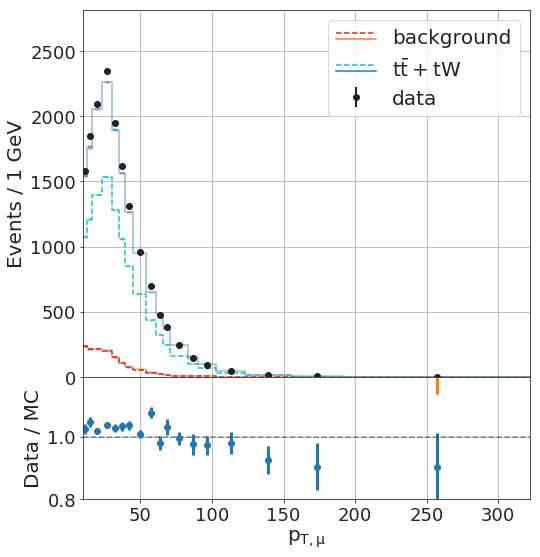

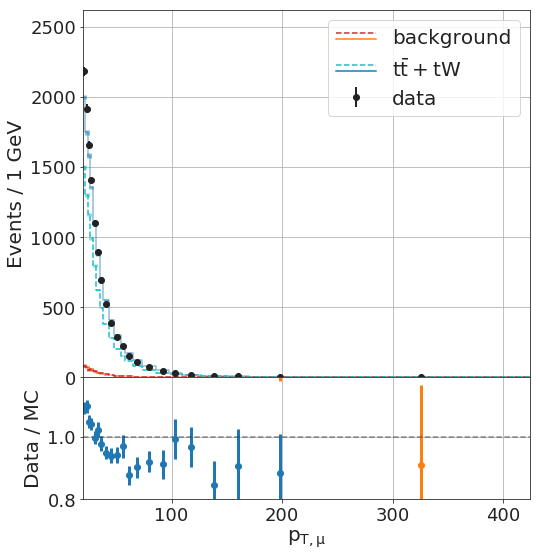

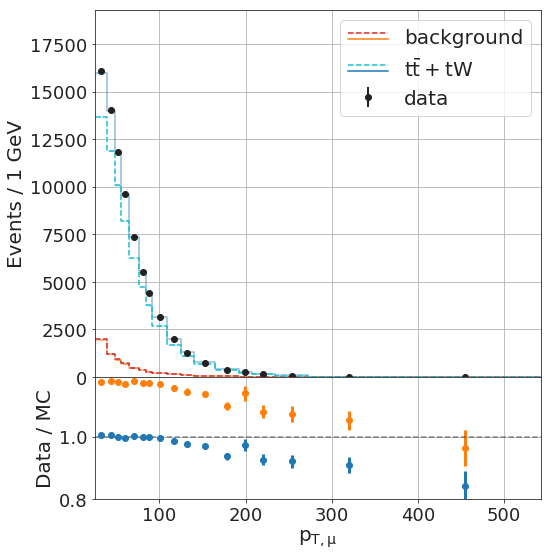

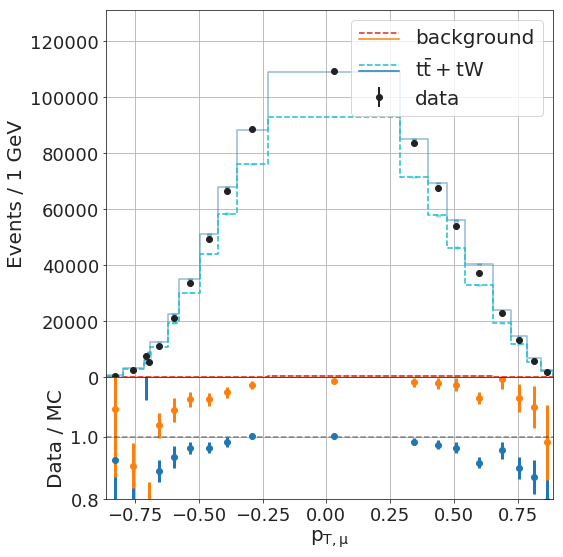

In [31]:
# make some plots
for selection in selections:
    fh.fit_plot(fit_data, selection, xlabel=r'$\sf p_{T,\mu}$', log_scale=False)